In [2]:
# libraries
import sys
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from tqdm import tqdm

# Exploratory Data Analysis (EDA)

In [167]:
pd.set_option("display.max_colwidth", None) # expanding the output display

# load train dataset
train = pd.read_csv('./data/train.csv')
print(f'train shape: {train.shape}')
train.head(3)

train shape: (3657801, 7)


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0


In [168]:
# load metadata dataset
metadata = pd.read_csv('./data/metadata.csv', sep=';')
print(f'metadata shape: {metadata.shape}')
metadata.head(3)

metadata shape: (33144, 30)


,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfermedades,Psicólogos",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video Juegos",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z


In [169]:
# metadata 'category'
metadata['category'].value_counts()

Infantil/Dibujos Animados    5491
Drama/Romance                2771
Comedia                      1780
Drama                        1709
Comedia/Romance              1274
                             ... 
Terror/Aventura                 1
Documental/Moda                 1
Investigación/Crimen            1
Drama/Religión                  1
Moda/Documental                 1
Name: category, Length: 221, dtype: int64

In [170]:
# split the category based on the separator
asset_category = [x.split('/') for x in metadata['category']]
# retrieve the all the unique categories in the metadata
all_assets_categories = sorted(list(set(itertools.chain.from_iterable(asset_category))))
# quick look at the all the categories within the data
print(all_assets_categories)

['Accion', 'Acción', 'Animación', 'Animales', 'Aventura', 'Aventuras', 'Biografía', 'Bélico', 'Ciencia', 'Ciencia Ficción', 'Ciencia ficción', 'Cocina', 'Comedia', 'Competencia', 'Crimen', 'Cultura', 'Decodificador Flow', 'Deporte', 'Dibujos Animados', 'Dibujos animados', 'Documental', 'Drama', 'Entretenimiento', 'Entrevistas', 'Espectáculo', 'Familia', 'Familiar', 'Fantasía', 'Historia', 'Humor', 'Infantil', 'Infantil, Comedia', 'Interés General', 'Investigación', 'Magazine', 'Moda', 'Musical', 'Música', 'Naturaleza', 'Periodístico', 'Policial', 'Político', 'Reality', 'Religión', 'Restauración', 'Romance', 'Suspenso', 'Teatro', 'Terror', 'Tutoriales', 'Viajes', 'Western']


In [171]:
# cleaning metadata 'category'
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Accion', 'Acción'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Aventuras', 'Aventura'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Ciencia Ficción', 'Ciencia ficción'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Dibujos Animados', 'Dibujos animados'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Familia', 'Familiar'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Familiarr', 'Familiar'))
metadata['category'] = metadata['category'].apply(lambda x: x.replace('Infantil, Comedia', 'Infantil'))

# split the category based on the separator
asset_category = [x.split('/') for x in metadata['category']]

# retrieve the all the unique categories in the metadata
all_assets_categories = sorted(list(set(itertools.chain.from_iterable(asset_category))))

# quick look at the all the categories within the data
print(all_assets_categories)

['Acción', 'Animación', 'Animales', 'Aventura', 'Biografía', 'Bélico', 'Ciencia', 'Ciencia ficción', 'Cocina', 'Comedia', 'Competencia', 'Crimen', 'Cultura', 'Decodificador Flow', 'Deporte', 'Dibujos animados', 'Documental', 'Drama', 'Entretenimiento', 'Entrevistas', 'Espectáculo', 'Familiar', 'Fantasía', 'Historia', 'Humor', 'Infantil', 'Interés General', 'Investigación', 'Magazine', 'Moda', 'Musical', 'Música', 'Naturaleza', 'Periodístico', 'Policial', 'Político', 'Reality', 'Religión', 'Restauración', 'Romance', 'Suspenso', 'Teatro', 'Terror', 'Tutoriales', 'Viajes', 'Western']


In [172]:
# merging datasets
df = pd.merge(left=train, right=metadata,
              left_on='asset_id', right_on='asset_id',
              how='left'
              )
print(f'df shape: {df.shape}')

df shape: (3657801, 36)


In [173]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657801 entries, 0 to 3657800
Data columns (total 36 columns):
 #   Column              Dtype  
---  ------              -----  
 0   customer_id         int64  
 1   account_id          int64  
 2   device_type         object 
 3   asset_id            float64
 4   tunein              object 
 5   tuneout             object 
 6   resume              int64  
 7   content_id          float64
 8   title               object 
 9   reduced_title       object 
 10  episode_title       object 
 11  show_type           object 
 12  released_year       float64
 13  country_of_origin   object 
 14  category            object 
 15  keywords            object 
 16  description         object 
 17  reduced_desc        object 
 18  cast_first_name     object 
 19  credits_first_name  object 
 20  run_time_min        float64
 21  audience            object 
 22  made_for_tv         object 
 23  close_caption       object 
 24  sex_rating          obje

In [174]:
# feature selection
df = df[['account_id', 'device_type', 'asset_id', 'tunein',
       'tuneout', 'resume', 'content_id', 'title', 'category', 'show_type',
       'run_time_min', 'end_vod_date']]

In [175]:
# checking missing values
df.isna().mean()*100

account_id      0.000000
device_type     0.000793
asset_id        0.000601
tunein          0.000000
tuneout         0.000000
resume          0.000000
content_id      0.003882
title           0.000601
category        0.000601
show_type       0.000957
run_time_min    0.000601
end_vod_date    0.000601
dtype: float64

In [176]:
# removing na
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.dropna()
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657801
Number of rows after drop duplicates: 3657617


In [177]:
# checking and removing of duplicates
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.drop_duplicates(keep='first')
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657617
Number of rows after drop duplicates: 3657579


In [178]:
# transforming dates in datetime object
df['tunein'] = pd.to_datetime(df['tunein'], format='%Y-%m-%d %H:%M:%S')
df['tuneout'] = pd.to_datetime(df['tuneout'], format='%Y-%m-%d %H:%M:%S')
df['end_vod_date'] = pd.to_datetime(df['end_vod_date'], format='%Y-%m-%dT%H:%M:%S')\
    .dt.tz_localize(None) # Z at the ends of str indicates Zulú UTC, so i need to remove the timezone

# calculate time_watched (difference between tuneout - tunein)
df['time_watched'] = df['tuneout'] - df['tunein']
# transform time_watched (minutes) to time_watched_seconds (seconds)
df['time_watched_seconds'] = df['time_watched'].apply(lambda x: x.seconds)

# transform run_time (minutes) to run_time_seconds (seconds)
df['run_time_seconds'] = df['run_time_min']*60

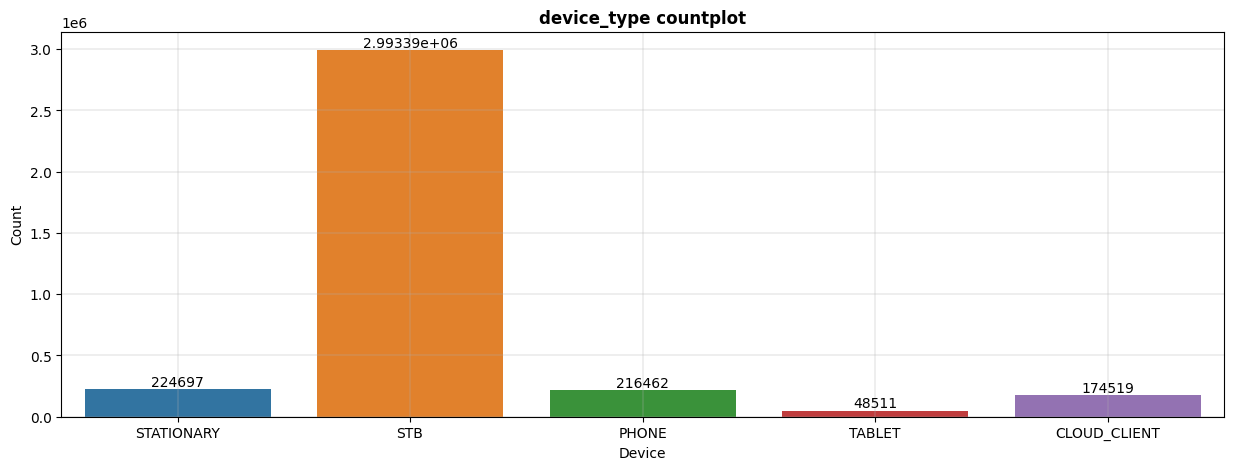

In [179]:
# ploting device_type
plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df, x='device_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Device')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('device_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

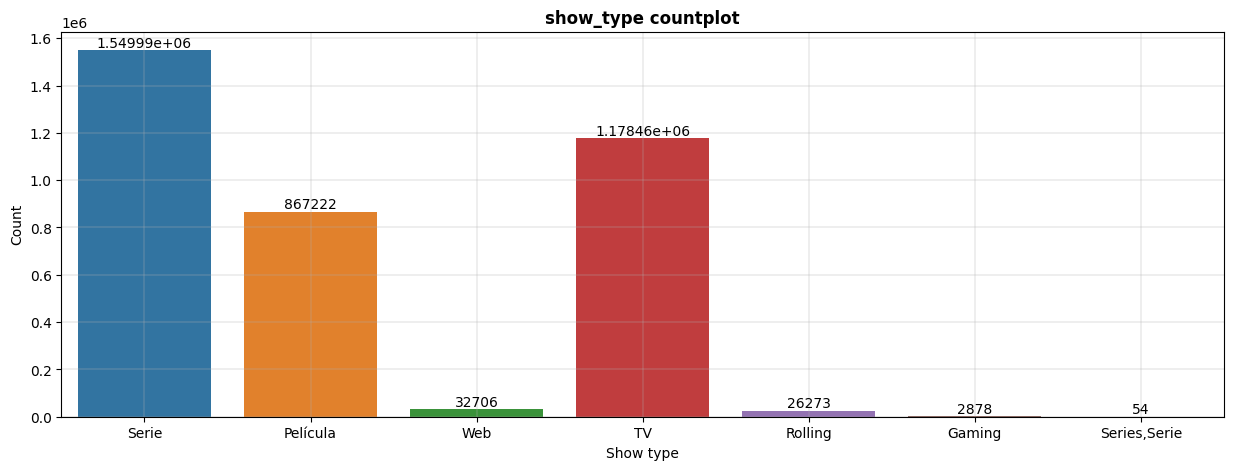

In [180]:
# ploting show_type
plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

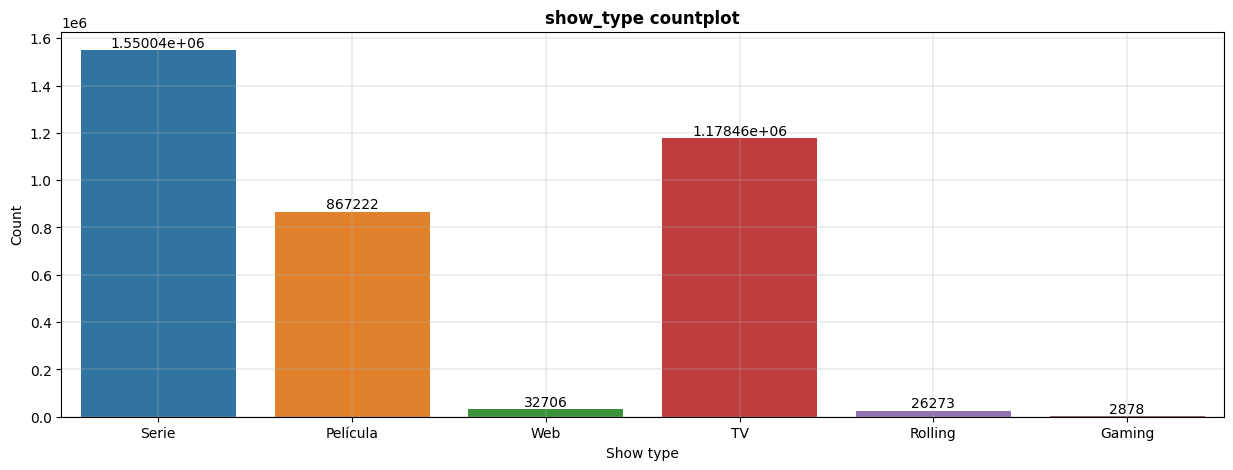

In [181]:
# modify 'Series,Serie' show_type category
df['show_type'] = df['show_type'].apply(lambda x: 'Serie' if x == 'Series,Serie' else x)

# ploting show_type
plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [182]:
# customers, accounts, assets and contents
print(f'Number of unique accounts: {df["account_id"].nunique()}')
print(f'Number of unique assets: {df["asset_id"].nunique()}')
print(f'Number of unique contents: {df["content_id"].nunique()}')

Number of unique accounts: 113873
Number of unique assets: 23975
Number of unique contents: 4062


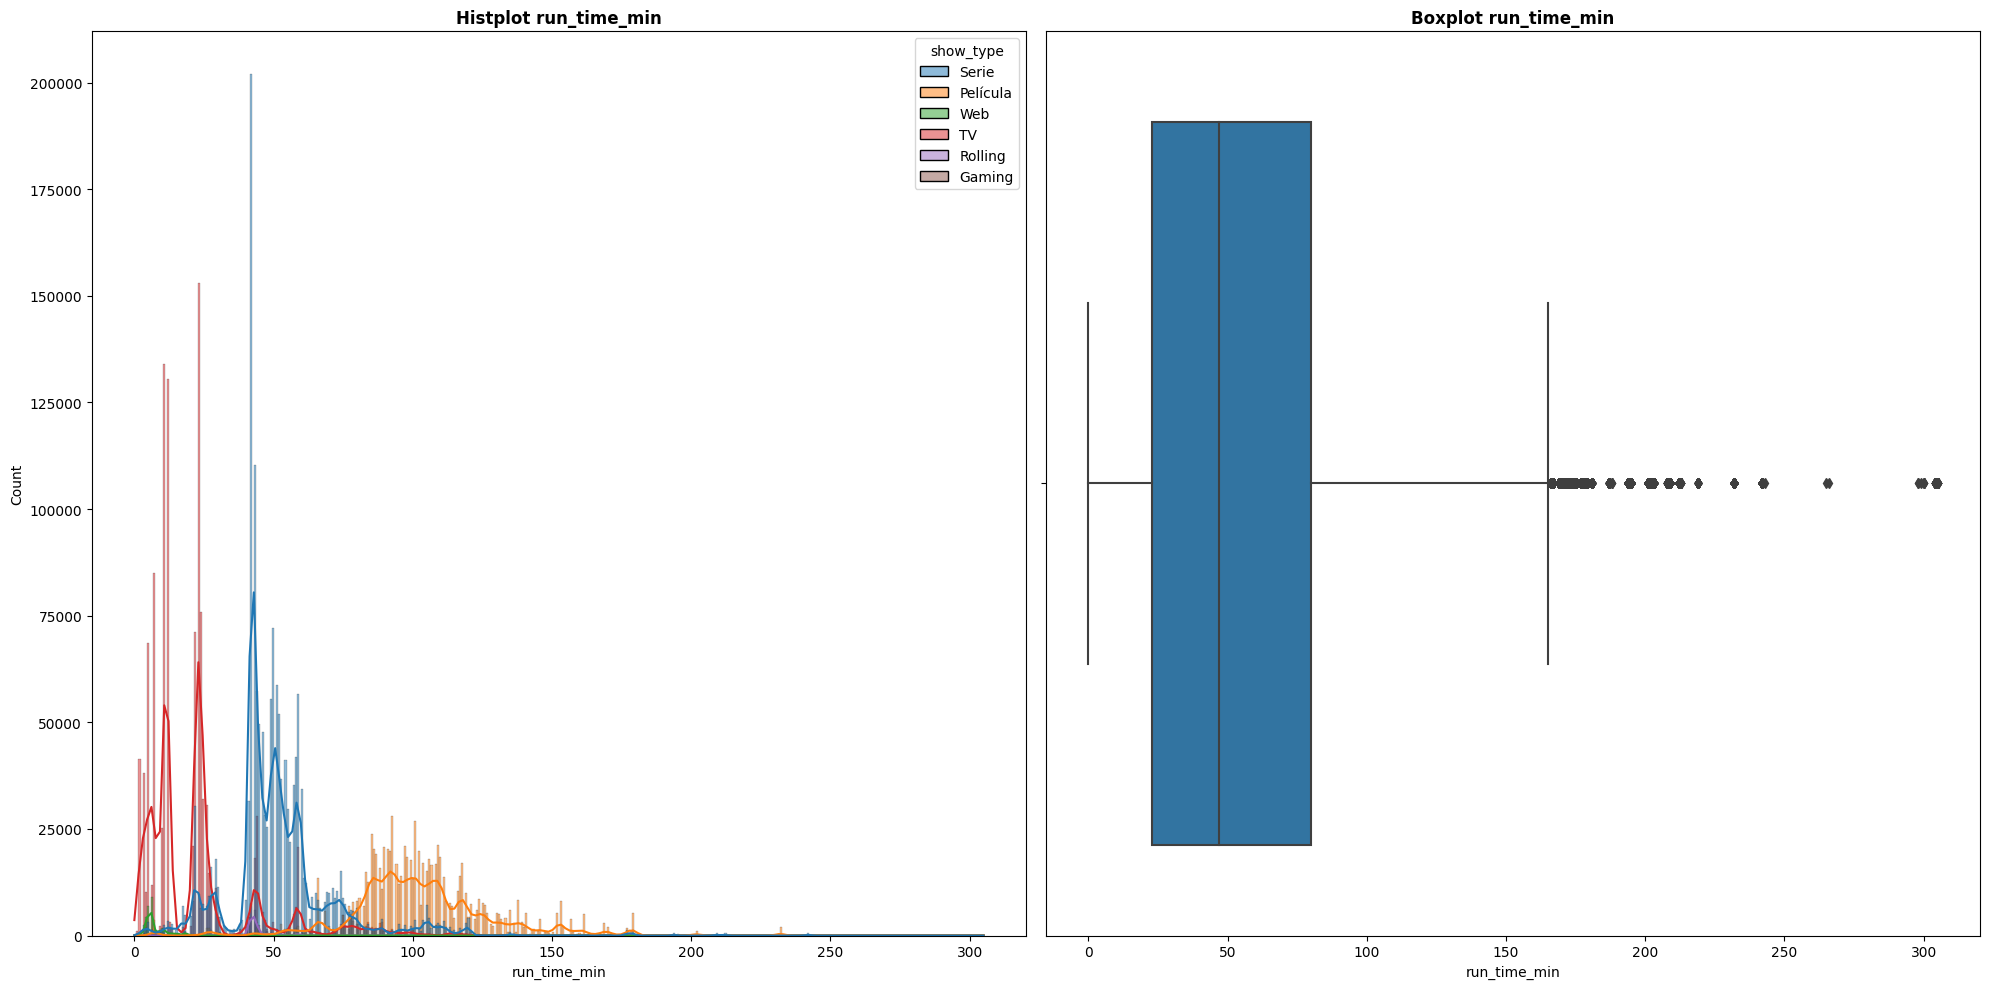

In [183]:
# checking assets duration
numerical_features = ['run_time_min']
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(20, 10))

for i, feature in enumerate(numerical_features):
    ax[0] = sns.histplot(x=df[feature], ax=ax[0], kde=True, hue=df['show_type'])
    ax[0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[1] = sns.boxplot(x=df[feature], ax=ax[1])
    ax[1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

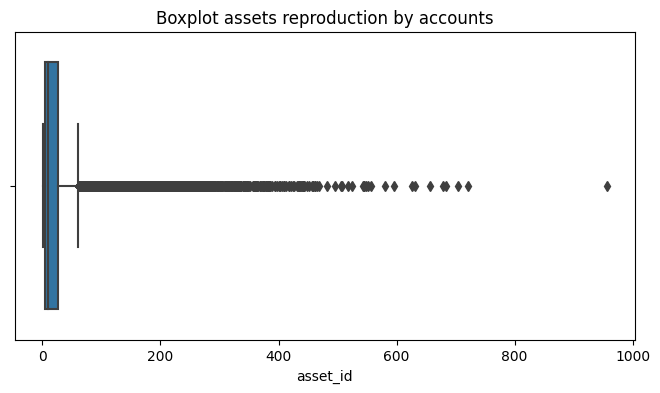

,asset_id
count,113873.000000
mean,22.741264
std,34.901985
min,1.000000
25%,4.000000
50%,10.000000
75%,27.000000
max,956.000000


In [184]:
aux = df.groupby('account_id').agg({'asset_id': 'nunique'})
plt.figure(figsize=(8,4))
plt.title('Boxplot assets reproduction by accounts')
sns.boxplot(x=aux.asset_id)
plt.show()

aux.describe()

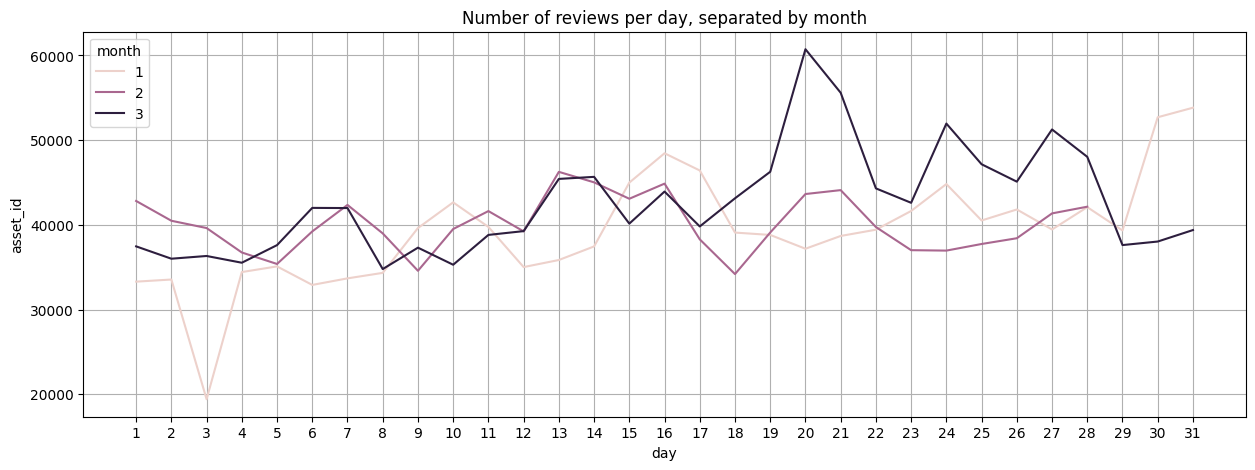

In [185]:
# ploting visualizations/day-month
aux = df.copy()
aux['year'] = df['tunein'].dt.year
aux['month'] = df['tunein'].dt.month
aux['day'] = df['tunein'].dt.day
aux = aux.groupby(['month', 'day'], as_index=False).count()[['month', 'day', 'asset_id']]

plt.figure(figsize=(15,5))
sns.lineplot(data=aux, x='day', y='asset_id', hue='month')
plt.title("Number of reviews per day, separated by month")
plt.xticks([x for x in range(aux['day'].min(), aux['day'].max() +1,1)])
plt.grid(0.3)
plt.show()

# PREDICTION

## train test split

In [204]:
# train test split
train = df[df['tunein'] < datetime(year=2021, month=3, day=1)].copy()
test = df[df['tunein'] >= datetime(year=2021, month=3, day=1)].copy()
print(f'Length train: {len(train)}')
print(f'Length test: {len(test)}')
print(f'Number of unique account_id in train: {train["account_id"].nunique()}')
print(f'Number of unique account_id in test: {test["account_id"].nunique()}')

Length train: 2338968
Length test: 1318611
Number of unique account_id in train: 99645
Number of unique account_id in test: 87623


## not available content (NAC) and cold start

In [205]:
# not available content (NAC)
NAC_df = train[['content_id', 'end_vod_date']].groupby('content_id', as_index=False).agg({'end_vod_date': 'max'})

NAC = NAC_df[NAC_df['end_vod_date'] < datetime(year=2021, month=3, day=31)]['content_id'].values

# cold start
cold_start_content = train.groupby('content_id', as_index=False).agg({'account_id':'nunique'})\
    .sort_values(by='account_id', ascending=False)
cold_start = cold_start_content['content_id'][0:50].values
cold_start = [x for x in cold_start if x not in NAC]

print(len(NAC))
print(len(cold_start))

915
46


## implicit rating

In [206]:
# the user liked the asset if he/she watched more than 70% of the asset's duration
train['rate_watch'] = train['run_time_seconds']*0.70 - train['time_watched_seconds']
train['rate_watch'] = train['rate_watch'].apply(lambda x: 1 if x <= 0 else 0) # (1: like asset, 0: not like asset)

# the user liked the asset if he/she watched more than 70% of the asset's duration or watched twice or more ('resume' == 1)
train['rate_watch'] = (train['rate_watch'] + train['resume']).apply(lambda x: 0 if x == 0 else 1)

# select necessary features
train = train[['account_id', 'content_id', 'rate_watch', 'title', 'end_vod_date']]
test = test[['account_id', 'content_id', 'title', 'end_vod_date']]
print(f'% liked entries: {train["rate_watch"].sum() / len(train)*100}')

train.head()

% liked entries: 79.39150941782871


,account_id,content_id,rate_watch,title,end_vod_date
0,90627,2040.0,1,T:5 Ep:08 This is Us,2021-06-30 23:59:59
6,3388,2100.0,1,T:1 Ep:14 The Resident,2021-06-30 23:59:59
7,3388,2100.0,1,T:1 Ep:14 The Resident,2021-06-30 23:59:59
8,3388,2100.0,0,T:2 Ep:01 The Resident,2021-06-30 23:59:59
9,3388,2100.0,1,T:2 Ep:01 The Resident,2021-06-30 23:59:59


In [208]:
# grouping by 'account_id' and 'content_id' because the recomendations must be by 'content_id' and not 'asset_id'
train = train.groupby(['account_id', 'content_id'], as_index=False)\
            .agg({'account_id': 'first',
                  'content_id': 'first',
                  'rate_watch': 'mean',
                  'title': 'first',
                  'end_vod_date': 'max' # keep the max value
                  })

# in tv programs (Series), the rate will be an average of episodes, so it needs to be converted to 0s and 1s values
train['rate_watch'] = train['rate_watch'].apply(lambda x: 0 if x < 0.05 else 1)

# grouping by 'account_id' and 'content_id' because the recomendations must be by 'content_id' and not 'asset_id'
test = test.groupby(['account_id', 'content_id'], as_index=False)\
            .agg({'account_id': 'first',
                  'content_id': 'first',
                  'title': 'first',
                  'end_vod_date': 'max' # keep the max value
                  })

In [209]:
# interaction matrix using rate_watch
interactions = train[['account_id', 'content_id', 'rate_watch']].copy() # features
interactions_matrix = pd.pivot_table(interactions, index='account_id', columns='content_id', values='rate_watch') # matrix creation
interactions_matrix = interactions_matrix.fillna(0) # fill na interactions_matrix
interactions_matrix_csr = csr_matrix(interactions_matrix.values) # sparsing interactions_matrix

# # calculate sparsity
# sparsity = 1.0 - (np.count_nonzero(interactions_matrix) / float(interactions_matrix.size))
# print(f'Sparsity: {sparsity}') # sparsity is too high!! collaborative filtering may not be a good idea

## modeling

In [210]:
def lightfm_reco(model, cold_start,
    interactions_matrix, interactions_matrix_csr, test,
    n_recomendations, not_available_content=[],
    feature_account='account_id', feature_content='content_id'):

    """
    model: lightfm fitted model
    cold_start (list): recomended content to new users
    not_available_content (numpy.1darray): not available content
    interactions_matrix (pd.Dataframe): 
    interactions_matrix_csr ():
    test (pd.DataFrame): test df
    n_recomendations (int): number of recomendations
    not_available_content (list, default=None): not available content
    feature_account (str, default='account_id'): feature account_id name in dataframes
    feature_content (str, default='content_id'): feature content_id name in dataframes

    Returns:
        recomendations_df (pd.DataFrame): df with recomendations
    """

    # recomendations dict
    recomendations_dict = {
        'account_id': [],
        'recomendations': [],
        'cold_start': []
        }

    # accounts and items
    accounts_train = list(interactions_matrix.index)
    item_ids = np.arange(interactions_matrix.shape[1])
    test_accounts = test[feature_account].unique()

    account_dict = {}
    counter = 0
    for i in accounts_train:
        account_dict[i] = counter
        counter += 1

    # recomendations for each account in test
    for account_test in tqdm(test_accounts):
        # check if the account is in interactions_matrix
        if account_test in list(accounts_train):
            # ff the user is in train, it is not cold start --> model recomendation
            account_x = account_dict[account_test] # look for the user's index in the matrix (transform id to index)

            # generate predictions for the account
            predictions = model.predict(user_ids=account_x, item_ids=item_ids)

            # ordering the predictions from lowest to highest and keeping 100
            scores = pd.Series(predictions)
            scores.index = interactions_matrix.columns
            scores = list(pd.Series(scores.sort_values(ascending=False).index))[:100]

            # get list of contents previously viewed by the account (in the train set)
            watched_contents = train[train[feature_account] == account_test][feature_content].unique()

            # filter already viewed content and keep the rest
            recomendations = [x for x in scores if x not in watched_contents]
            # filter not available content and keep the rest
            # if not_available_content.any():
            recomendations = [x for x in recomendations if x not in not_available_content]

            # save recomendations in a dict
            recomendations_dict['account_id'].append(account_test)
            recomendations_dict['recomendations'].append(recomendations[0:n_recomendations])
            recomendations_dict['cold_start'].append(False)

        # cold start (most popular content recomendation)
        else:
            recomendations_dict['account_id'].append(account_test)
            recomendations_dict['recomendations'].append(cold_start)
            recomendations_dict['cold_start'].append(True)

    # creating a df with recomendations
    recomendations_df = pd.DataFrame(recomendations_dict)

    return recomendations_df


def map(recomendations_df, test,
        feature_account='account_id', feature_content='content_id'):

    """
    recomendations_df (pd.DataFrame): df with recomendations
    test (pd.DataFrame): test df
    feature_account (str, default='account_id'): feature account_id name in dataframes
    feature_content (str, default='content_id'): feature content_id name in dataframes

    Returns:
        MAP (float): mean average precision
    """

    # getting what users watched in the test
    ideal_recomendations_df =\
    test\
    .sort_values(by=[feature_account], ascending=False)\
    .groupby([feature_account], as_index=False)\
    .agg({feature_content: "unique"})

    # merging recomendations_df with ideal_recomendations df
    df_map = ideal_recomendations_df.merge(recomendations_df,
                                    how='left',
                                    left_on=feature_account, right_on=feature_account)

    # getting MAP
    average_precisions = [] # empty list to store all average precisions
    for pred, label in df_map[['recomendations', feature_content]].values:
        n = len(pred) # number of recommended items
        arange = np.arange(n, dtype=np.int32) + 1. # index in base 1
        rel_k = np.in1d(pred[:n], label) # list of booleans indicating the relevance of each item
        tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # list with the counter of true positives
        denom = arange[rel_k] # positions where the reliant items are located
        average_precision = (tp / denom).sum() / len(label) # average precision
        average_precisions.append(average_precision)
    MAP = np.mean(average_precisions)

    return MAP, df_map

In [211]:
# only interaction_matrix model
learning_rate = 0.03
seed = 42
epochs = 25
components = [20]
dicci = {}

for component in components:
# model based only in interaction_matrix
    model_im = LightFM(loss='warp', no_components=component, learning_rate=learning_rate,
                    random_state=seed)
    model_im = model_im.fit(interactions_matrix_csr, epochs=epochs)

    recomendations_df_im = lightfm_reco(model_im, cold_start,
                                interactions_matrix, interactions_matrix_csr, test,
                                20, not_available_content=NAC)

    MAP_im, df_map_im = map(recomendations_df_im, test)
    dicci[component] = MAP_im
    print(MAP_im)

dicci

100%|██████████| 87623/87623 [13:35<00:00, 107.47it/s]


0.02840339294500174


{20: 0.02840339294500174}

In [ ]:
{20: 0.02840339294500174} # con 0.70

In [192]:
# model hybrid based in interaction_matrix and assets categories
dataset = Dataset()
dataset.fit(train['account_id'],
            train['content_id'],
            item_features=all_assets_categories)

item_features = dataset.build_item_features((x, y) for x, y in zip(train['content_id'], asset_category))

interactions, weights = dataset.build_interactions(train.iloc[:, 0:3].values) # only account_id, content_id and rate_watch

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions,
    test_percentage=0.2,
    random_state=np.random.RandomState(42)
    )

model_hybrid = LightFM(loss='warp', no_components=20,
                 learning_rate=learning_rate,
                 item_alpha=0.001,
                 random_state=np.random.RandomState(seed)
                )

model_hybrid.fit(interactions=train_interactions,
           item_features=item_features,
           epochs=epochs
           )


for component in components:
    # model based only in interaction_matrix
    model_hybrid = LightFM(loss='warp', no_components=component, learning_rate=learning_rate,
                    random_state=seed)
    model_hybrid = model_hybrid.fit(interactions_matrix_csr, epochs=epochs)

    recomendations_df_hybrid = lightfm_reco(model_hybrid, cold_start,
                                interactions_matrix, interactions_matrix_csr, test,
                                20, not_available_content=NAC)

    MAP_hybrid, df_map_hybrid = map(recomendations_df_hybrid, test)
    dicci[component] = MAP_hybrid
    print(MAP_hybrid)

100%|██████████| 87623/87623 [09:41<00:00, 150.68it/s]


0.028056659016448406


# modeling

In [193]:
metadata_grouped = metadata.groupby('content_id', as_index=False).agg({'title': 'first'})

entry2_watched = df_map_im.iloc[1]['content_id']
entry2_recomended_im = df_map_im.iloc[1]['recomendations']

In [194]:
metadata_grouped.loc[metadata_grouped['content_id'].isin(entry2_watched), "title"]

280                    Atrápame Si Puedes
460                           El vengador
562     Transformers: El último caballero
1947              Mi abuelo es un peligro
2337                          La rebelión
2406              T:1 Ep:01 The Leftovers
2543                      Primer ministro
3164                     Tómalo con calma
3182            Upgrade – Máquina asesina
3482                     Socias en guerra
3696                   Las Torres Gemelas
3974                     Escuela nocturna
3981          T:1 Ep:03 Yo conocí a Jesús
4004                      Rey de ladrones
4053                 Rápidos y furiosos 4
4105                            El Retiro
4174                    Nicholas Nickleby
4193              Terror en lo profundo 3
4307            Jack Reacher: Sin regreso
Name: title, dtype: object

In [195]:
metadata_grouped.loc[metadata_grouped['content_id'].isin(entry2_recomended_im), "title"]

296                 Rocky III
474      El expreso del miedo
491               El mecánico
517                   Creed 2
549                  Rocky IV
1309                 Bad Boys
1329           Qué pasó ayer?
2219              Dos Más Dos
2811           El fútbol o yo
2813     Mamá se fue de viaje
2823       Los que aman odian
2842                   Guasón
3205         Fuga de pretoria
3377                    Messi
3514    Bad Boys para siempre
3671           El Apocalípsis
3705                 Ip Man 4
3800            Cosa de minas
3812        El último samurai
3857                  Ronaldo
Name: title, dtype: object